In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors

#from sklearnex import patch_sklearn
#patch_sklearn()

from skimage.color import rgb2gray, rgb2hsv, hsv2rgb
from skimage.io import imread, imshow
from sklearn.cluster import KMeans, MiniBatchKMeans

# requires v0.22.0<=sklearn<=v0.23.2
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

import yellowbrick

In [3]:

df_tissue = pd.read_csv('/Users/tarunmamidi/Documents/Development/ditto-1/data/train_F_3_0_1_nssnv/merged_data-train_F_3_0_1_nssnv.csv')
df_tissue.head()

,SYMBOL,Feature,Consequence,clinvar_CLNREVSTAT,clinvar_CLNSIG,Chromosome,Position,Alternate Allele,Reference Allele,ID,...,integrated_fitCons_score,phastCons100way_vertebrate,phastCons30way_mammalian,phyloP100way_vertebrate,phyloP30way_mammalian,IMPACT_HIGH,BIOTYPE_protein_coding,BIOTYPE_polymorphic_pseudogene,BIOTYPE_IG_C_gene,BIOTYPE_non_stop_decay
0,SAMD11,ENST00000342066,missense_variant,criteria_provided&_single_submitter,Likely_benign,chr1,930248,A,G,var_0,...,0.59774,1.0,0.063,2.486,0.985,0.0,1.0,0.0,0.0,0.0
1,SAMD11,ENST00000420190,missense_variant,criteria_provided&_single_submitter,Likely_benign,chr1,930248,A,G,var_1,...,0.59774,1.0,0.063,2.486,0.985,0.0,1.0,0.0,0.0,0.0
2,SAMD11,ENST00000437963,missense_variant,criteria_provided&_single_submitter,Likely_benign,chr1,930248,A,G,var_2,...,0.59774,1.0,0.063,2.486,0.985,0.0,1.0,0.0,0.0,0.0
3,SAMD11,ENST00000616016,missense_variant,criteria_provided&_single_submitter,Likely_benign,chr1,930248,A,G,var_3,...,0.59774,1.0,0.063,2.486,0.985,0.0,1.0,0.0,0.0,0.0
4,SAMD11,ENST00000616125,missense_variant,criteria_provided&_single_submitter,Likely_benign,chr1,930248,A,G,var_4,...,0.59774,1.0,0.063,2.486,0.985,0.0,1.0,0.0,0.0,0.0


In [4]:
df_tissue = df_tissue.drop(['SYMBOL','Feature',	'Consequence',	'clinvar_CLNREVSTAT',	'clinvar_CLNSIG',	'Chromosome',	'Position',	'Alternate Allele'	,'Reference Allele',	'ID'], axis=1)
df_tissue.head()

,gnomADv3_AF,SIFT,PolyPhen,CADD_PHRED,MetaSVM_score,FATHMM_score,MutationAssessor_score,PROVEAN_score,VEST4_score,GERP,...,integrated_fitCons_score,phastCons100way_vertebrate,phastCons30way_mammalian,phyloP100way_vertebrate,phyloP30way_mammalian,IMPACT_HIGH,BIOTYPE_protein_coding,BIOTYPE_polymorphic_pseudogene,BIOTYPE_IG_C_gene,BIOTYPE_non_stop_decay
0,0.003488,0.01,0.014,21.9,-1.0342,-1.26,2.015,-3.25,0.261,4.12,...,0.59774,1.0,0.063,2.486,0.985,0.0,1.0,0.0,0.0,0.0
1,0.003488,0.02,0.168,21.9,-1.0342,-1.26,2.215,-2.88,0.762,4.12,...,0.59774,1.0,0.063,2.486,0.985,0.0,1.0,0.0,0.0,0.0
2,0.003488,0.02,0.014,21.9,-1.0342,-1.26,2.215,-3.66,0.762,4.12,...,0.59774,1.0,0.063,2.486,0.985,0.0,1.0,0.0,0.0,0.0
3,0.003488,0.00,0.747,21.9,-1.0342,-1.26,2.215,-2.88,0.459,4.12,...,0.59774,1.0,0.063,2.486,0.985,0.0,1.0,0.0,0.0,0.0
4,0.003488,0.00,0.031,21.9,-1.0342,-1.26,2.215,-2.88,0.265,4.12,...,0.59774,1.0,0.063,2.486,0.985,0.0,1.0,0.0,0.0,0.0


# Gap statistic

29


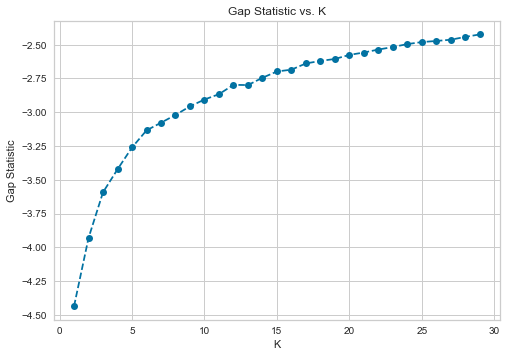

In [4]:
# Gap Statistic for K means
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = MiniBatchKMeans(k, batch_size=6144)
           # km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
        # Fit cluster to original data and create dispersion
        km = MiniBatchKMeans(k, batch_size=6144)
        #km= KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)

# run function
score_g, df = optimalK(df_tissue, nrefs=5, maxClusters=30)

plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');
print(score_g)
plt.show()

# Elbow

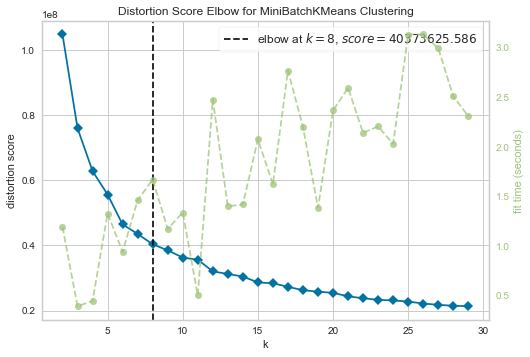

<AxesSubplot:title={'center':'Distortion Score Elbow for MiniBatchKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = MiniBatchKMeans(batch_size=6144)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(df_tissue)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

# Silhouette 

In [ ]:
# Taking a long time
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = MiniBatchKMeans(batch_size=6144)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(df_tissue)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Calinski Harabasz

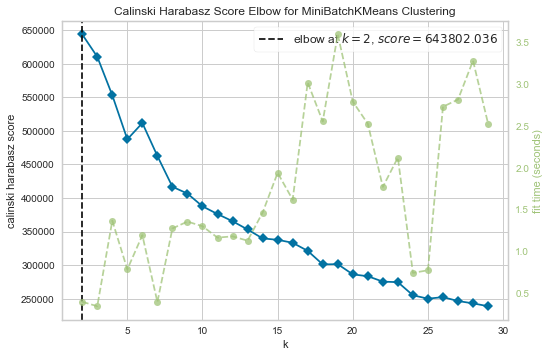

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for MiniBatchKMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [7]:
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = MiniBatchKMeans(batch_size=6144)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(df_tissue)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Davies Bouldin 
minimum is best

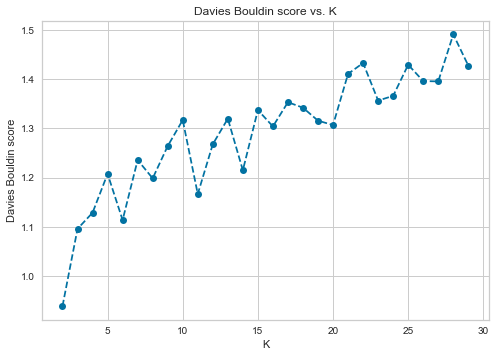

In [8]:
from sklearn.metrics import davies_bouldin_score
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = MiniBatchKMeans(n_clusters=center, batch_size=6144)
    # Then fit the model to your data using the fit method
    model = kmeans.fit_predict(data)
    
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(data, model)
    
    return score
scores = []
centers = list(range(2,30))
for center in centers:
    scores.append(get_kmeans_score(df_tissue, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');
# want minimum
plt.show()

# Dendogram for Heirarchical Clustering

In [9]:
# wanted 17Tb of memory!
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df_tissue, method='ward'))

# BIC for GMM
minimum is best

In [5]:
from sklearn.mixture import GaussianMixture
n_components = range(1, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov)
        gmm.fit(df_tissue)
        score.append((cov,n_comp,gmm.bic(df_tissue)))
score

In [ ]:
score_df = pd.DataFrame(score)

In [ ]:
score_df.sort_values(by=2, ascending=True)

,0,1,2
115,full,29,4.872934e+07
110,full,24,4.873586e+07
114,full,28,4.873629e+07
111,full,25,4.873729e+07
112,full,26,4.874048e+07
...,...,...,...
1,spherical,2,6.377148e+07
29,tied,1,6.598105e+07
87,full,1,6.598105e+07
58,diag,1,6.804825e+07
